# Bollinger Bands Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='z')

In [2]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [3]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [4]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [5]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [9]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    tmp['series'] = tmp['BuySignal'] + tmp['SellSignal']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [112]:
def BB(pr_df, ndays=20, sigma_lvl=2):
    pr = pr_df.copy()
    pr['UpperBand'] = pr['close'].rolling(ndays, min_periods=1).mean()+pr['close'].rolling(ndays, min_periods=1).std()*sigma_lvl
    pr['LowerBand'] = pr['close'].rolling(ndays, min_periods=1).mean()-pr['close'].rolling(ndays, min_periods=1).std()*sigma_lvl
    pr['PB'] = (pr['close'] - pr['LowerBand']) / (pr['UpperBand'] - pr['LowerBand'])
    pr['BandWidth'] = (pr['UpperBand'] - pr['LowerBand']) / pr['close'].rolling(ndays, min_periods=1).mean() * 100
    return pr.fillna(method='bfill')

In [25]:
def BB_Statistics(bb):
    code = bb.columns[0]
    num = len(bb)
    in_nm = 0
    up_nm = 0
    down_nm = 0
    for i in range(len(bb)):
        if bb[code][i] > bb['UpperBand'][i] :
            up_nm += 1
        elif bb[code][i] < bb['LowerBand'][i] : 
            down_nm += 1
        elif bb['LowerBand'][i] <= bb[code][i] <= bb['UpperBand'][i] : 
            in_nm += 1
    rst = pd.DataFrame(columns = ['Total','Inside','Upper','Lower'], index=[code])
    rst.loc[code,'Total'] = num
    rst.loc[code,'Inside'] = round(in_nm/num,2)
    rst.loc[code,'Upper'] = round(up_nm/num,2)
    rst.loc[code,'Lower'] = round(down_nm/num,2)
    return rst

In [113]:
def BB_Signal_v1(dff):
    """
    Simply when close price does crossover the upper band then buy, else sell.
    """
    df = dff.copy()
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['close'][i] < df['LowerBand'][i] and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['close'][i] > df['UpperBand'][i] and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    
    """
    For the first position being long, if SellSignal is prior to BuySignal
    remove that position..
    """
    firstSell = df[df['SellSignal'].notnull()].index[0]
    firstBuy = df[df['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        df.loc[firstSell,'SellSignal'] = np.nan
    return df

In [114]:
def BB_Run_v1(start, end, code,  ndays=14, sigma_lvl=2, doplot=True):
    pr = ldr.GetPricelv2(start, end, [code])
    pr = pr.rename(columns={code:'close'})
    bb = BB(pr, ndays=ndays, sigma_lvl=sigma_lvl)
    if doplot :
        plt.style.use('fivethirtyeight')
        bb.plot(figsize=(8,6))
        plt.title("Bollinger Bands for {}".format(code))
    bb_sig = BB_Signal_v1(bb)
    BB_Statistics(bb)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(bb_sig.index, bb_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(bb_sig.index, bb_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(bb_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('Bollinger Bands on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(bb_sig)
    rst.index = [code]
    return rst

### 1) Simple Bollinger Bands Strategy (Volatility Breakout)
* Buy when close price does crossover the upper band, else sell.
* Its name is not the one usually knowns as Rarry William's Volatility Breakout Strategy.

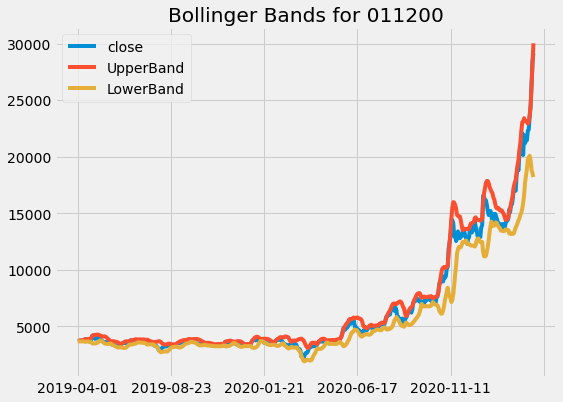

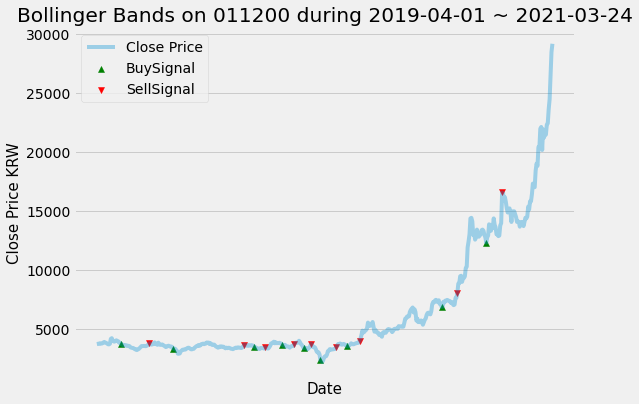

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
011200,3.38,0.89,0.49,-0.01,0.18,1.15,1.14,9,2.45


In [84]:
BB_Run_v1('2019-04-01','2021-03-24','011200',10,2,True)

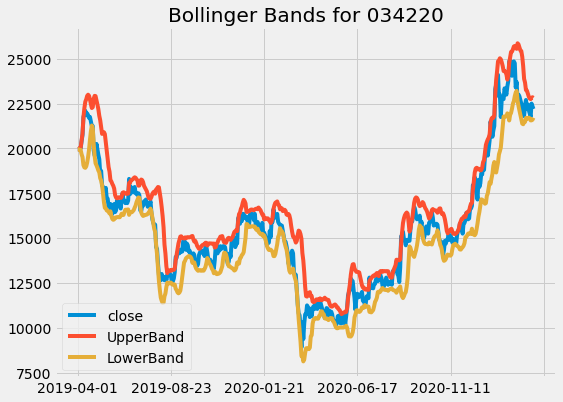

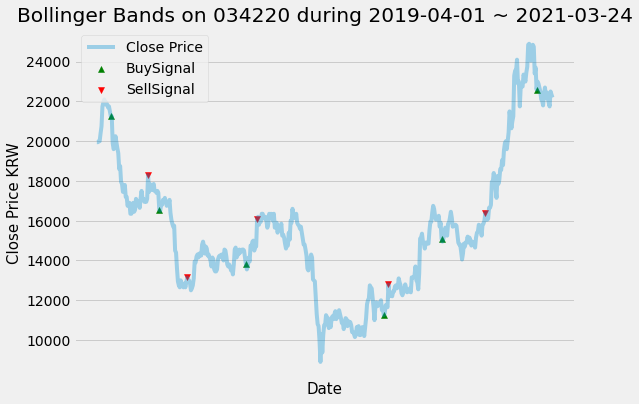

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
034220,0.99,0.6,0.17,-0.21,0.6,1.01,1,5,-0.14


In [97]:
BB_Run_v1('2019-04-01','2021-03-24','034220',10,2,True)

---

### 2) Trend Following Strategy

* When PB<20 and MFI<20 then sell, else PB>80 and MFI>80 then buy.
* Using MFI for trend momentum supports Bollinger Bands not to be a false signal.

In [115]:
def MFI(pr_df, ndays=14):
    pr = pr_df.copy()
    pr['TypicalPrice'] = round((pr['high']+pr['low']+pr['close'])/3,3)
    pr['MF'] = pr['TypicalPrice'] * pr['volume']
    
    P_flow = []
    N_flow = []
    P_flow.append(0)
    N_flow.append(0)
    
    for i in range(1, len(pr)):
        if pr['TypicalPrice'][i] > pr['TypicalPrice'][i-1]:
            P_flow.append(pr['MF'][i])
            N_flow.append(0)
        elif pr['TypicalPrice'][i] < pr['TypicalPrice'][i-1]:
            N_flow.append(pr['MF'][i])
            P_flow.append(0)
        else :
            P_flow.append(0)
            N_flow.append(0)
    pr['P_MF'] = P_flow
    pr['N_MF'] = N_flow
    pr['P_MF'] = pr['P_MF'].rolling(ndays,min_periods=1).sum()
    pr['N_MF'] = pr['N_MF'].rolling(ndays,min_periods=1).sum()
    pr['MFI'] = 100 * (pr['P_MF'] / (pr['P_MF'] + pr['N_MF']))
    return pr

In [143]:
def BB_Signal_v2(dff, buy=20, sell=80):
    """
    With MFI if MFI>80 and PB>0.8 buy, else MFI<20 and PB<0.2 sell.
    """
    df = dff.copy()
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['PB'][i] < buy/100 and df['MFI'][i] < buy and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['PB'][i] > sell/100 and df['MFI'][i] > sell and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    
    """
    For the first position being long, if SellSignal is prior to BuySignal
    remove that position..
    """
    firstSell = df[df['SellSignal'].notnull()].index[0]
    firstBuy = df[df['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        df.loc[firstSell,'SellSignal'] = np.nan
    return df

In [124]:
def BB_Run_v2(start, end, code,  ndays=14, sigma_lvl=2, buy=80, sell=20, doplot=True):
    pr = ldr.GetPricelv1(start, end, [code]).sort_values(by=['DATE'])
    pr = pr.rename(columns={'adjprice':'close','OPEN':'open'})
    pr.index = pr['DATE'].to_list()
    pr = MFI(pr, ndays=ndays)
    bb = BB(pr, ndays=ndays, sigma_lvl=sigma_lvl)
    if doplot :
        plt.style.use('fivethirtyeight')
        tmp = bb[['PB','MFI']]
        tmp['PB'] = tmp['PB'] * 100
        tmp.plot(figsize=(10,6))
        plt.title("Bollinger Bands for {}".format(code))
    bb_sig = BB_Signal_v2(bb, buy=buy, sell=sell)
    #BB_Statistics(bb)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(bb_sig.index, bb_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(bb_sig.index, bb_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(bb_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('Bollinger Bands on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(bb_sig)
    rst.index = [code]
    return rst

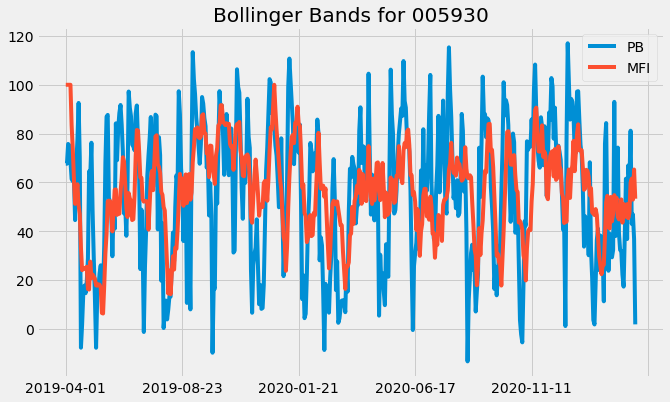

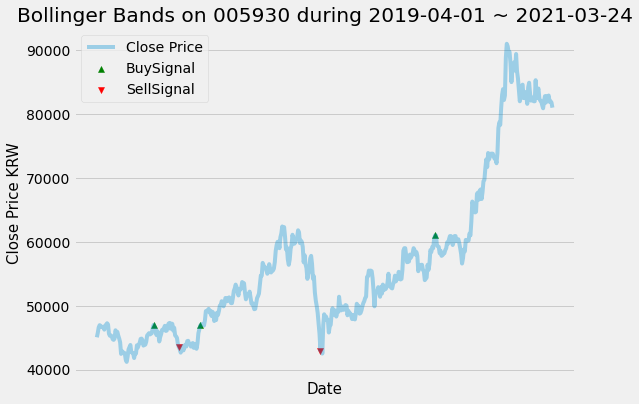

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,0.85,0,-0.07,-0.08,0.32,0.92,0.92,2,-20.37


In [131]:
BB_Run_v2('2019-04-01','2021-03-24','005930',10,2,20,80,True)

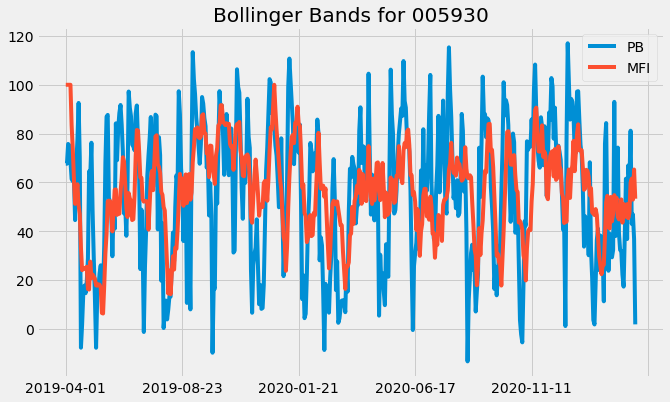

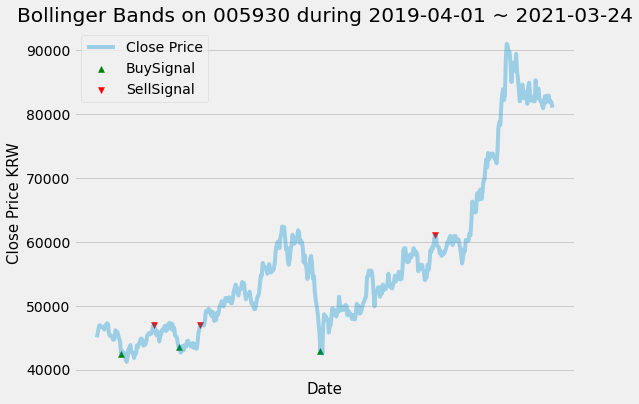

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.7,1,0.42,0.08,0.32,1.2,1.19,3,1.66


In [133]:
BB_Run_v2('2019-04-01','2021-03-24','005930',10,2,20,80,True)

### Conclusion
* The first plot is derived as an original logic that MFI>80 and PB>0.8 for buying signal and the second one is exactly opposite signal made.
* It's ridiculous that an opposite signal give me a better result.
* As MFI is used as an indicator catching trend momentum that oversold/bought will reversely affect the price movement, opposite signal may be right.
* Since there is no correct method in stock market, it makes sense.

---

### 3) Reversals Strategy

* Someone may be more familiar with 'WM pattern' than 'Reversals'.
* 'Intraday Intensitiy' will be added for measuring the strength of trend.

In [154]:
def IntradayIntensity(pr_df, ndays=21):
    pr = pr_df.copy()
    pr['II'] = (2 * pr['close'] - pr['high'] - pr['low']) / (pr['high'] - pr['low']) * pr['volume']
    pr['PII'] = pr['II'].rolling(ndays, min_periods=1).sum() / pr['volume'].rolling(ndays, min_periods=1).sum() * 100
    """
    the first PII value is nothing at all so just copy the next value..
    """
    pr.loc[pr.index[0],'PII'] = pr.loc[pr.index[1],'PII']
    
    return pr

In [158]:
def BB_Signal_v3(dff, buy=0.05, sell=0.95):
    """
    With II if II>0 and PB<0.05 buy, else II<0 and PB>0.95 sell.
    """
    df = dff.copy()
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['PB'][i] < buy and df['II'][i] > 0 and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['PB'][i] > sell and df['II'][i] < 0 and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    
    """
    For the first position being long, if SellSignal is prior to BuySignal
    remove that position..
    """
    firstSell = df[df['SellSignal'].notnull()].index[0]
    firstBuy = df[df['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        df.loc[firstSell,'SellSignal'] = np.nan
    return df

In [163]:
def BB_Run_v3(start, end, code,  ndays=14, sigma_lvl=2, buy=0.05, sell=0.95, doplot=True):
    pr = ldr.GetPricelv1(start, end, [code]).sort_values(by=['DATE'])
    pr = pr.rename(columns={'adjprice':'close','OPEN':'open'})
    pr.index = pr['DATE'].to_list()
    pr = IntradayIntensity(pr, ndays=ndays)
    bb = BB(pr, ndays=ndays, sigma_lvl=sigma_lvl)
    if doplot :
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(8,6))
        plt.bar(bb.reset_index().index, bb['II'], color='g',label='IntradyIntensity(%)Ndays')
        plt.legend(loc='upper left')
        plt.title("Bollinger Bands for {}".format(code))
    bb_sig = BB_Signal_v3(bb, buy=buy, sell=sell)
    #BB_Statistics(bb)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(bb_sig.index, bb_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(bb_sig.index, bb_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(bb_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('Bollinger Bands on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(bb_sig)
    rst.index = [code]
    return rst

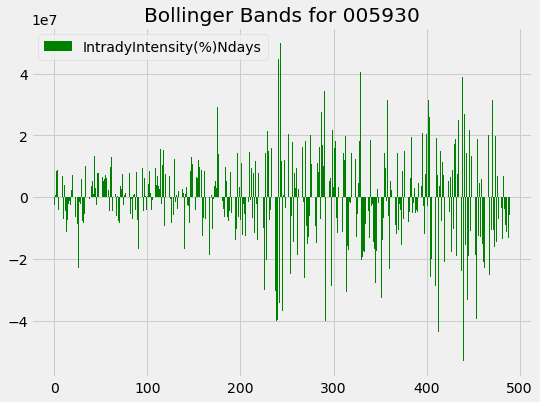

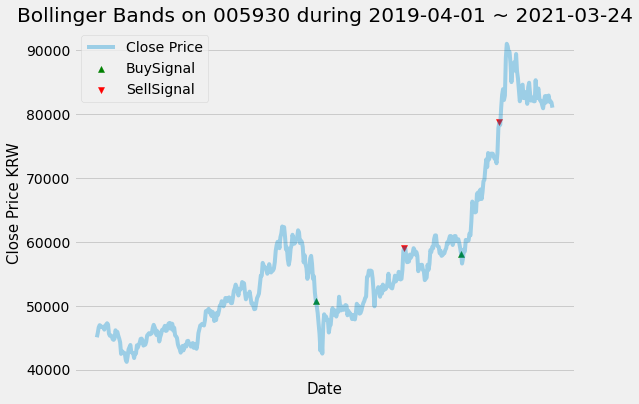

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.57,1,0.35,0.16,0.32,1.26,1.25,2,2.46


In [184]:
BB_Run_v3('2019-04-01','2021-03-24','005930',10,2,0.05,0.95,True)

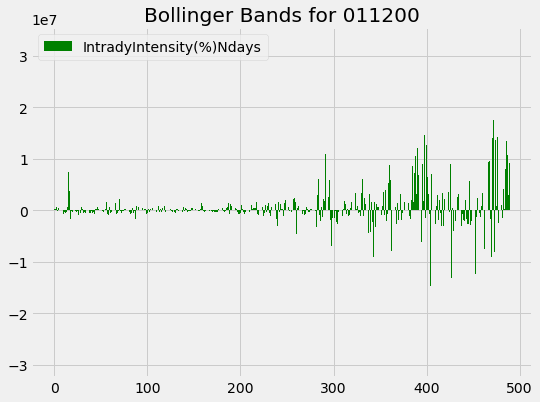

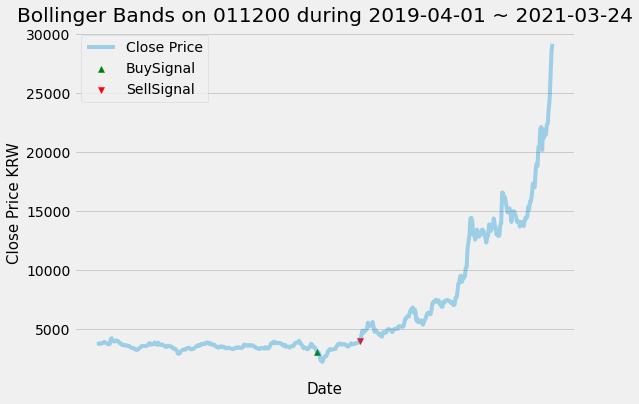

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
011200,1.31,1,0.31,0.31,0.18,1.31,1.31,1,NaN


In [182]:
BB_Run_v3('2019-04-01','2021-03-24','011200',10,2,0.05,0.95,True)

In [191]:
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,BB_Run_v3(start, end, cd,10,1.5,0.05,0.95,False)])

In [192]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.38,0.75,0.21,-0.08,0.32,1.09,1.08,4,1.12
005935,1.16,0.75,0.13,-0.05,0.33,1.04,1.04,4,0.54
034220,0.86,0.6,0.15,-0.29,0.6,0.99,0.97,5,-0.38
066570,0.78,0.6,0.07,-0.21,0.23,0.96,0.95,5,-0.91


### Conclusion
* As you can see from above plots, It may be good or bad.
* By using Intraday Intensity actual flow of money could be catched but in the sense of 'reversal' strategy it could be falsely positioned.
* Must not be used as a stand-alone indicator.

---

### 4) Band Width Squeeze

* Lastly, I'll check a band width's signal which is known as 'squeeze'.
* It itself doesn't make a position at all since following pattern could be 'Surge/Plummet'.

In [247]:
def SqueezeBreakout(bb_df, sigma_lvl=1):
    bb = bb_df.copy()
    bb_rt = bb[['BandWidth']].pct_change()
    std = bb_rt['BandWidth'].std()
    mean = bb_rt['BandWidth'].mean()
    breakout = bb_rt[(bb_rt.BandWidth >= mean + std * sigma_lvl)].index.to_list()
    if len(breakout) == 0 :
        return False
    else :
        breakout_series = []
        for idx, row in bb.iterrows():
            if idx in breakout :
                breakout_series.append(row.BandWidth)
            else :
                breakout_series.append(np.nan)
        bb['BreakOut'] = breakout_series
        return bb

In [256]:
def BB_BW_Squeeze(start, end, code, ndays=14, sigma_lvl=2, buy=0.05, sell=0.95, doplot=True):
    pr = ldr.GetPricelv1(start, end, [code]).sort_values(by=['DATE'])
    pr = pr.rename(columns={'adjprice':'close','OPEN':'open'})
    pr.index = pr['DATE'].to_list()
    pr = IntradayIntensity(pr, ndays=ndays)
    bb = BB(pr, ndays=ndays, sigma_lvl=sigma_lvl)
    bb['MA'] = bb['close'].rolling(ndays,min_periods=1).mean()
    
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(14,10))
    plt.subplot(2,1,1)
    plt.plot(bb.reset_index().index, bb['close'], color='#0000ff', linestyle='dashed', label='Close')
    plt.plot(bb.reset_index().index, bb['UpperBand'], color='r', linestyle='dashed',label='UpperBand')
    plt.plot(bb.reset_index().index, bb['LowerBand'], color='c', linestyle='dashed',label='LowerBand')
    plt.plot(bb.reset_index().index, bb['MA'],color='k', linestyle='dashed',label='Moving Average')
    plt.fill_between(bb.reset_index().index, bb['UpperBand'], bb['LowerBand'], color='gray')
    plt.title('Bollinger Band : {}'.format(code))
    plt.legend(loc='upper left')

    plt.subplot(2,1,2)
    plt.plot(bb.reset_index().index, bb['BandWidth'],color='m',alpha=0.5,label='BandWidth')
    bb_sqz = SqueezeBreakout(bb, sigma_lvl = 1.5)
    plt.plot(bb_sqz.reset_index().index, bb_sqz['BreakOut'], color='g', marker='^',alpha=1)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()
    return bb

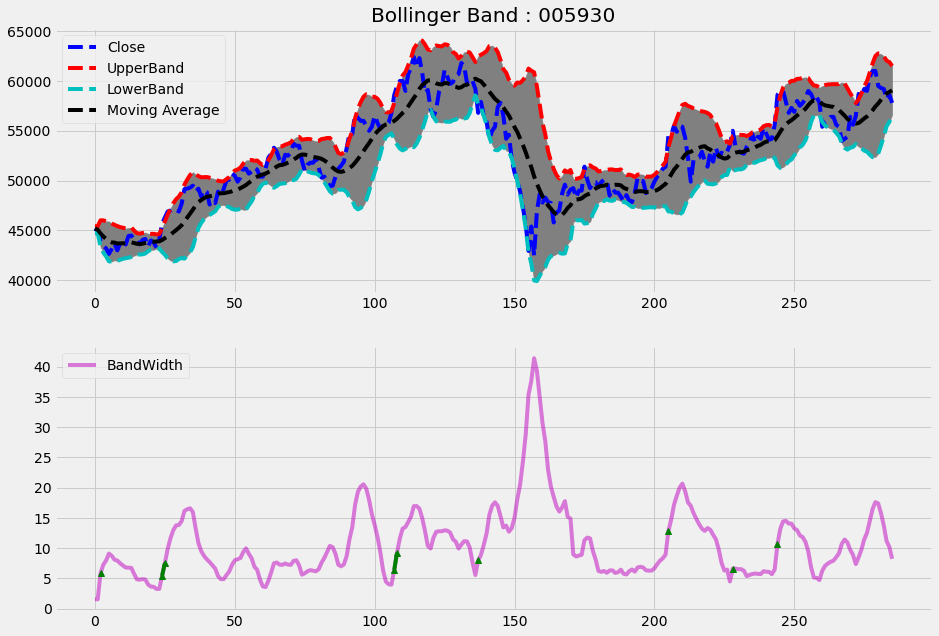

In [257]:
bb = BB_BW_Squeeze('2019-08-01','2020-09-24','005930')

### Conclusion
* It will be useful when our stocks have steady movement.
* Preparing for a breakout is possible by using this Squeeze-Breakout.